#### This is a notebook to simulate eoe10 cell on lionrock for performing RF fingerprinting using multiple tap RNN model

1. build physical models for the PIC

In [1]:
## readin pretrained PIC data

import csv
import matplotlib.pyplot as plt
import numpy as np

def read_spec(filename):

    with open(filename, mode ='r')as file:
        csvFile = csv.reader(file)
        lines = []
        for line in csvFile:
            lines.append(line)
        freq = []    
        pwr = []
        for line in lines[13:]:
            freq.append(float(line[0]))
            pwr.append(float(line[1]))
        freq = np.array(freq)
        pwr = np.array(pwr)
    return freq, pwr

from scipy.signal import find_peaks
import numpy as np

fn = "lionrock_c12_24.csv"
freq, pwr = read_spec(fn)
peaks, _ = find_peaks(-pwr,height=-np.min(pwr)-10, width=10)

oft = 22
pf = freq[peaks]+oft
pf_r = pf-np.round(pf/50)*50
fig, axs = plt.subplots(2,5,figsize=(25,5))
ym = (-15,15)
for i in range(5):
    axs[0][i].plot(pf_r[i::10], '-o')
    axs[0][i].set_ylim(ym)
for i in range(5):
    axs[1][i].plot(pf_r[i+5::10], '-o')
    axs[1][i].set_ylim(ym)
plt.show()

idxs = [2,2,2,2,2,
        2,2,2,1,1]
plt.figure(figsize=(25,5))
plt.plot(freq, pwr)
pks = []
errs = []
for i in range(10):
    pkss = peaks[i::10]
    idx = idxs[i]
    pks.append(pkss[idx])
    pk = pkss[idx]
    plt.text(freq[pk], pwr[pk]-1,'{:.0f}'.format(i+1),fontsize=20, horizontalalignment='center')
    plt.text(freq[pk], pwr[pk]-2,'{:.0f}'.format(freq[pk]+oft),fontsize=10, horizontalalignment='center')
    error = (freq[pk]+oft)-round((freq[pk]+oft)/50)*50
    errs.append(error)
    plt.text(freq[pk], pwr[pk]-3,'{:.0f}'.format(error),fontsize=10, horizontalalignment='center')
plt.plot(freq[pks], pwr[pks], "o")
plt.vlines([193700,195950],np.min(pwr),np.max(pwr),colors='tab:red')
errs = np.array(errs)
plt.title(fn+", offset={:}, error={:.2f}, {:.2f}, {:.2f}".format(oft,np.mean(errs),np.max(errs),np.min(errs)))
plt.show()

<Figure size 2500x500 with 10 Axes>

<Figure size 2500x500 with 1 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from os.path import dirname, join as pjoin
import scipy.io as sio

## Load Input Data

In [2]:
# if you would like to preprocess the origianl .mat data, then preprocessing = True 
preprocessing = True
if preprocessing:
    data_dir = '/mnt/hddraid1/ResidualData'
    print(data_dir)
    device_mat_frame = np.empty((30,), dtype=object)
    for i in range(0,30):
        device_mat_frame[i] = pjoin(data_dir, 'Residuals_Device{}.mat'.format(int(i+11)))

/mnt/hddraid1/ResidualData


In [3]:
from tqdm import tqdm
if preprocessing:
    device_mat_contents = np.empty((30,), dtype=object)
    for i in tqdm(range(0,30)):
        device_mat_contents[i] = sio.loadmat(device_mat_frame[i])

100%|██████████| 30/30 [02:46<00:00,  6.11s/it]


## Define training and test dataset

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from scipy import signal
def packet_data_from_mat_to_torch_dataloader(original_mat_data, device_num=30, part_num=16, batch_size=100, whole_packet=True):
    device_number = device_num
    part_number = part_num
    total_train_device_label = []
    total_dev_device_label = []
    total_test_device_label = []
    train_filtered_I = []
    train_filtered_Q = []
    test_filtered_I = []
    test_filtered_Q = []
    dev_filtered_I = []
    dev_filtered_Q = []
    fc = 2
    fs = 16
    b, a = signal.butter(4, fc/(fs/2))

    for device_idx in tqdm(range(device_number), leave=True, position=0):
        for part_idx in range(part_number):
            transmission_number = original_mat_data[device_idx]['residuals'][part_idx][0].shape[0]
            for i in (range(transmission_number)):
                if whole_packet:
                    if (i < transmission_number*0.80):
                        total_train_device_label.append(np.array([device_idx]))
                        train_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))
                        train_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))
                    elif (i < transmission_number*0.90):
                        total_dev_device_label.append(np.array([device_idx]))
                        dev_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))
                        dev_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))
                    else:
                        total_test_device_label.append(np.array([device_idx]))
                        test_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))
                        test_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i].reshape(-1,))))                                        
                else:
                    for j in range(17):
                        if (i < transmission_number*0.80):
                            total_train_device_label.append(np.array([device_idx]))
                            train_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))
                            train_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))
                        elif (i < transmission_number*0.90):
                            total_dev_device_label.append(np.array([device_idx]))
                            dev_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))
                            dev_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))
                        else:
                            total_test_device_label.append(np.array([device_idx]))
                            test_filtered_I.append(signal.filtfilt(b,a, np.real(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))
                            test_filtered_Q.append(signal.filtfilt(b,a, np.imag(original_mat_data[device_idx]['residuals'][part_idx][0][i][j])))                                        


    train_filter_data = []
    train_labels = total_train_device_label

    test_filter_data = []
    test_labels = total_test_device_label

    dev_filter_data = []
    dev_labels = total_dev_device_label
    length = len(train_filtered_I)                                      
    for j in tqdm(range(length), leave=True, position=0):
        train_filter_IQ = np.vstack((train_filtered_I[j], train_filtered_Q[j])).T # np.array([[train_filtered_I[j][k], train_filtered_Q[j][k]] for k in range(len(train_filtered_Q[j]))])
        train_filter_data.append([train_filter_IQ, train_labels[j]])
        if j < len(test_filtered_I):
            test_filter_IQ = np.vstack((test_filtered_I[j], test_filtered_Q[j])).T # np.array([[test_filtered_I[j][k], test_filtered_Q[j][k]] for k in range(len(test_filtered_Q[j]))])
#             del test_filtered_I[j], test_filtered_Q[j]
            test_filter_data.append([test_filter_IQ, test_labels[j]])
        if j < len(dev_filtered_I):
            dev_filter_IQ = np.vstack((dev_filtered_I[j], dev_filtered_Q[j])).T # np.array([[dev_filtered_I[j][k], dev_filtered_Q[j][k]] for k in range(len(dev_filtered_Q[j]))])
#             del dev_filtered_I[j], dev_filtered_Q[j]
            dev_filter_data.append([dev_filter_IQ, dev_labels[j]])
    # np.save('train_data',train_filter_data)
    # np.save('dev_data',dev_filter_data)
    # np.save('test_data',test_filter_data)
    trainloader_filter = data.DataLoader(train_filter_data, shuffle=True, batch_size=batch_size)
    del train_filter_data
    devloader_filter = data.DataLoader(dev_filter_data, shuffle=False, batch_size=batch_size)
    del dev_filter_data
    testloader_filter = data.DataLoader(test_filter_data, shuffle=False, batch_size=batch_size)
    del test_filter_data
    return trainloader_filter, devloader_filter, testloader_filter

## Define torch dataloader 

In [5]:
whole_packet_flag = True # using a whole packet as data unit or not
bs = 100 # batch size
trainloader_filter, devloader_filter, testloader_filter = packet_data_from_mat_to_torch_dataloader(device_mat_contents, device_num=30, part_num=5, batch_size=bs, whole_packet=whole_packet_flag)

100%|██████████| 26939/26939 [00:03<00:00, 6909.83it/s]


In [17]:
# data = next(iter(trainloader_filter))
# np.shape(data[0])
len(trainloader_filter.dataset)

2700

In [18]:
# trainloader_filter = torch.load('dataloader/train_dataloader.pth')
# testloader_filter = torch.load('dataloader/test_dataloader.pth')
# devloader_filter = torch.load('dataloader/dev_dataloader.pth')

## Train with noise using CTRNN-CNN model

In [20]:
def photonic_act(x): #experimentally measured photonic activation function
    denom = torch.mul(x,x) + torch.mul(0.3+0.25*x, 0.3+0.25*x) # torch.div(0.3, x) + 0.25
    out = torch.div(torch.mul(x,x), denom)
#     denom = torch.mul(denom, denom) + 1.0
    return out

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 10 # nn.Parameter(torch.linspace(10,12,hidden_size), requires_grad=False)
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size, bias=True)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=True)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(photonic_act(hidden))
        h_new = hidden * self.oneminusalpha +  self.alpha * (pre_activation)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(photonic_act(hidden))

        output = torch.stack(output, dim=0)
        return output, hidden
    
class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()

        # Continuous time RNN
#         self.rnn = nn.LSTM(input_size, hidden_size, batch_first=False, **kwargs)
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.conv0 = nn.Conv1d(in_channels = hidden_size, out_channels = 16, kernel_size=5, stride=1)#.to(device)
        torch.nn.init.xavier_uniform_(self.conv0.weight)#.to(device) # v0 (but no maxpool) v1 out_channels= 128, v2 64, v3 16, v4 4 and not using conv1
        self.conv1 = nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size=3, stride=1)#.to(device)
        torch.nn.init.xavier_uniform_(self.conv1.weight)#.to(device)
        self.fc2 = nn.Linear(in_features= 96, out_features=30)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        out = x * 625 #/ torch.std(x, dim=2).unsqueeze(2) # * 625
        out = out.permute(1,0,2)
        
        rnn_activity, _ = self.rnn(out) # bs, seq_len, hidden_dim (100, 17, hd)
        out = rnn_activity.permute(1,2,0)
        
        out = self.conv0(out)
        out = F.celu(out)
        out = nn.MaxPool1d(2)(out)
        out = self.conv1(out)
        out = F.celu(out)
        out = nn.MaxPool1d(2)(out)
                
        out = out.reshape(out.size(0),-1)#out.permute(0,2,1)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)

        return out, rnn_activity

In [21]:
hidden_size = 16
input_size = 64
output_size = 32
num_sec = 17
length = int(2048/input_size)
sec_len = 1024
net = RNNNet(input_size=64, hidden_size=hidden_size, dt=5)
data, label = next(iter(trainloader_filter))
data = data[:,0:sec_len*num_sec,:].float()
data = data.permute(0,2,1).reshape(data.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
data = data.reshape(data.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data.size(0)*num_sec, 64, 32).permute(0,2,1)
            
print(data.shape)
output, _ = net(data)
print(output.shape, _.shape)

torch.Size([1700, 32, 64])
torch.Size([1700, 30]) torch.Size([32, 1700, 16])


In [9]:
def train_noise(model, device, train_loader, optimizer, snr_list=np.array([10,15,20,25,30,35,40]), random_draw_snr=True, num_sec=17): # random_draw_snr=True means you want to train with noise data
    model.train()
    losses = []
    np.random.seed(123)
#     model.mask.test_mode = False
    for (data, target) in tqdm(train_loader, leave=True, position=0):
        target = target.reshape(-1,)
        data, target = data.to(device).float(), target.to(device)
        data = data[:,0:1024*num_sec,:]
            
        if random_draw_snr:
            snr = snr_list[np.random.randint(len(snr_list))]*1.0
            sigma_n = torch.unsqueeze(torch.std(data, dim=1)/(10**(snr/10))/np.sqrt(2), dim=1).repeat(1, data.size(1), 1).to(device)
            noise = torch.unsqueeze(torch.unsqueeze(torch.randn(data.size(1)), dim=0), dim=2).repeat(data.size(0),1,data.size(2)).to(device)
            data_noise = data + (sigma_n * noise)
            data_noise = data_noise.permute(0,2,1).reshape(data_noise.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
            data_noise = data_noise.reshape(data_noise.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data_noise.size(0)*num_sec, 64, 32).permute(0,2,1)
            data_all = data_noise
            target = torch.transpose(target.reshape(1,-1).repeat(17,1), 0, 1).reshape(-1,)
        else:
            data_all = data.permute(0,2,1).reshape(data.size(0),2,num_sec,-1).permute(0,2,1,3).reshape(data.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data.size(0)*num_sec, 64, 32).permute(0,2,1).unsqueeze(1).repeat(1,8,1,1)
            for idx, snr in enumerate(snr_list):
                sigma_n = torch.unsqueeze(torch.std(data, dim=1)/(10**(snr/10))/np.sqrt(2), dim=1).repeat(1, data.size(1), 1).to(device)
                noise = torch.unsqueeze(torch.unsqueeze(torch.randn(data.size(1)), dim=0), dim=2).repeat(data.size(0),1,data.size(2)).to(device)
                data_noise = data + (sigma_n * noise)
                data_noise = data_noise.permute(0,2,1).reshape(data_noise.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
                data_noise = data_noise.reshape(data_noise.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data_noise.size(0)*num_sec, 64, 32).permute(0,2,1)
                data_all[:,idx+1,:,:] = data_noise
            data_all = data_all.reshape(-1,32,64)
            target = target.reshape(1,-1).repeat(17*(len(snr_list)+1),1).T.reshape(-1,)
#         data_noise = data_noise.permute(0,2,1).reshape(data.size(0),2,17,-1).permute(0,2,1,3).reshape(data.size(0)*17,2,-1)

        optimizer.zero_grad()
        output, _ = model(data_all)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

def test_noise(model, device, test_loader, snr_list=[0,10,20,30], random_draw_snr=True, num_sec=17):
    model.eval()
    test_loss = 0
    correct = 0
    prediction = []
    label = []
    np.random.seed(123)
#     model.mask.test_mode = True
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=True, position=0):
            target = target.reshape(-1,)
            data, target = data.to(device).float(), target.to(device)
            data = data[:,0:1024*num_sec,:]
            if random_draw_snr:
                snr = snr_list[np.random.randint(len(snr_list))]
            else:
                snr = snr_list[-1]
            sigma_n = torch.unsqueeze(torch.std(data, dim=1)/(10**(snr/10))/np.sqrt(2), dim=1).repeat(1, data.size(1), 1).to(device)
            noise = torch.unsqueeze(torch.unsqueeze(torch.randn(data.size(1)), dim=0), dim=2).repeat(data.size(0),1,data.size(2)).to(device)
            data_noise = data + sigma_n * noise
#             data_noise = data_noise.permute(0,2,1).reshape(data.size(0),2,17,-1)#.permute(0,2,1,3).reshape(data.size(0)*17,2,-1)
            data_noise = data_noise.permute(0,2,1).reshape(data_noise.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
            data_noise = data_noise.reshape(data_noise.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data_noise.size(0), num_sec, 64, 32).permute(0,1,3,2)
            output_array = []            

            for i in range(num_sec):
                output_array.append(model(data_noise[:,i,:,:])[0])
            output_array = torch.stack(output_array)
            output = torch.mean(output_array, dim=0)
            

            test_loss += nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            prediction.append(pred)
            label.append(target)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy, prediction, label

## Study the effects of photonic weight precision

In [10]:
loaded = True
DEVICE = torch.device("cpu")
PATH = '/home/weipengz'
# model_name = 'WM_photonic_ctrnn_7device_2CNN_1FC_len=32_neuron16_noise.pt' #_aplha01, none
# model_name = 'WM_photonic_ctrnn_v3_30device_2CNN_1FC_len=32_neuron16.pt'   
model_name = 'snr61_39_ctrnn.pt'
if loaded:
    net_test = RNNNet(input_size=64, hidden_size=16, dt=5).to(DEVICE)
    net_test.load_state_dict(torch.load(pjoin(PATH, model_name)))
test_loader = testloader_filter
# net_test.readout = False
val_loss, accuracy, prediction, label = test_noise(net_test, DEVICE, test_loader, snr_list=[30])
print('accuracy:', accuracy, val_loss)


100%|██████████| 33/33 [00:08<00:00,  4.08it/s]

accuracy: 96.11178614823815 0.6641830331934468


In [11]:
num_sec = 17
with torch.no_grad():
    for data, target in tqdm(trainloader_filter, leave=True, position=0):
        target = target.reshape(-1,)
        data, target = data.to(DEVICE).float(), target.to(DEVICE)
        data = data[:,0:1024*num_sec,:]
        data = data.permute(0,2,1).reshape(data.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
        data = data.reshape(data.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data.size(0), num_sec, 64, 32).permute(0,1,3,2)
        output_array = []            

        for i in range(num_sec):
            output_array.append(net_test(data[:,i,:,:])[0])
        output_array = torch.stack(output_array)
        output = torch.mean(output_array, dim=0)
        print(output.shape)
        break

  0%|          | 0/270 [00:00<?, ?it/s]

torch.Size([100, 30])


In [12]:
test_data_scaled = []
test_label = []
with torch.no_grad():
    for data, target in tqdm(testloader_filter, leave=True, position=0):
        target = target.reshape(-1,)
        data, target = data.to(DEVICE).float(), target.to(DEVICE)
        data = data[:,0:1024*num_sec,:]
        data = data.permute(0,2,1).reshape(data.size(0),2,num_sec,-1).permute(0,2,1,3)#.reshape(data.size(0),num_sec,-1)
        data = data.reshape(data.size(0), num_sec, 2, 32, 32).permute(0,1,2,4,3).reshape(data.size(0), num_sec, 64, 32).permute(0,1,3,2)
        output_array = [] 
        data = data * 625
        test_data_scaled.append(data.detach().cpu().numpy())
        test_label.append(target.detach().cpu().numpy())
#         for i in range(num_sec):
            
#             output_array.append(net_test(data[:,i,:,:])[0])
#         break

100%|██████████| 33/33 [00:00<00:00, 48.94it/s]


In [13]:
%load_ext autoreload
%autoreload 2
from dependencies.photonics import PWB
from dependencies.mappers import PWBMapper, PWBArrayMapper
#  Miscellaneous helpers and functions

PWBArray_map = PWBArrayMapper()
precision_list = [2**(i)-1 for i in range(1,10)]
# rnn_input2h_w = PWBArray_map.build(net_test.rnn.input2h.weight.data.detach().cpu().numpy(), precision)

# fc2_w = PWBArray_map.build(net_test.fc_layers[2].weight.data.detach().cpu().numpy())

rnn_h2h_w_precision = []
for precision in precision_list:
    rnn_h2h_w_tensor = torch.zeros_like(net_test.rnn.h2h.weight.data)
    rnn_h2h_w = PWBArray_map.build(net_test.rnn.h2h.weight.data.detach().cpu().numpy(), precision)
    for i in range(rnn_h2h_w_tensor.size(0)):
        rnn_h2h_w_tensor[i] = torch.FloatTensor(rnn_h2h_w.pwbs[i].outputGain*(rnn_h2h_w.pwbs[i]._dropput-rnn_h2h_w.pwbs[i]._throughput))
    rnn_h2h_w_precision.append(rnn_h2h_w_tensor)
    
# print(rnn_h2h_w_precision)

In [14]:
for i,j in enumerate(precision_list):
    error_1 = torch.nn.functional.mse_loss(net_test.rnn.h2h.weight.data, rnn_h2h_w_precision[i]) # net.fc_layers[1].weight.data - fc1_w_tensor
    err_rate_1 = torch.mean((rnn_h2h_w_precision[i]-net_test.rnn.h2h.weight.data)/net_test.rnn.h2h.weight.data)
    print("Weight precision:", int(np.log(j+1)/np.log(2)), "MSE:", error_1, "error rate:", err_rate_1)

Weight precision: 1 MSE: tensor(0.9992) error rate: tensor(-11.8722)
Weight precision: 2 MSE: tensor(0.0173) error rate: tensor(-0.9877)
Weight precision: 3 MSE: tensor(0.0072) error rate: tensor(-0.7257)
Weight precision: 4 MSE: tensor(0.0019) error rate: tensor(-0.2878)
Weight precision: 5 MSE: tensor(0.0004) error rate: tensor(-0.1476)
Weight precision: 6 MSE: tensor(8.6311e-05) error rate: tensor(-0.0729)
Weight precision: 7 MSE: tensor(2.1775e-05) error rate: tensor(-0.0387)
Weight precision: 8 MSE: tensor(4.6726e-06) error rate: tensor(-0.0045)
Weight precision: 9 MSE: tensor(1.2997e-06) error rate: tensor(-0.0061)


In [15]:
acc_precisions = []
snr_list = [30,25,20,15,14,13,12,11,10,9,8,7,6,5]
# snr_list = [15,14,13,12,11,10]
for snr in snr_list: 
    acc_precision = []
    for i,j in enumerate(precision_list):
        net_test.rnn.h2h.weight.data = rnn_h2h_w_precision[i]
        val_loss, accuracy, prediction, label = test_noise(net_test, DEVICE, test_loader, snr_list=[snr])
        acc_precision.append(accuracy)
        print("SNR:", snr, "Weight precision:", int(np.log(j+1)/np.log(2)), 'accuracy:', accuracy)
    acc_precisions.append(acc_precision)

  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 2 accuracy: 14.641555285540704


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 3 accuracy: 6.713244228432564


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 4 accuracy: 34.993924665856625


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 5 accuracy: 49.30133657351154


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 6 accuracy: 93.07411907654921


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 7 accuracy: 92.2235722964763


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 8 accuracy: 95.86877278250304


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 30 Weight precision: 9 accuracy: 95.99027946537059


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 2 accuracy: 14.611178614823816


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 3 accuracy: 6.713244228432564


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 4 accuracy: 34.933171324422844


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 5 accuracy: 49.17982989064399


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 6 accuracy: 92.80072904009721


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 7 accuracy: 92.16281895504252


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 8 accuracy: 96.05103280680437


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 25 Weight precision: 9 accuracy: 95.9599027946537


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 2 accuracy: 14.580801944106925


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 3 accuracy: 6.804374240583232


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 4 accuracy: 35.388821385176186


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 5 accuracy: 48.8456865127582


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 6 accuracy: 92.70959902794654


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 7 accuracy: 91.70716889428918


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 8 accuracy: 95.65613608748481


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 20 Weight precision: 9 accuracy: 95.65613608748481


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 2 accuracy: 15.097205346294047


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 3 accuracy: 6.591737545565006


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 4 accuracy: 34.90279465370595


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 5 accuracy: 39.9453219927096


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 6 accuracy: 87.18104495747266


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 7 accuracy: 86.7861482381531


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 8 accuracy: 93.07411907654921


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 15 Weight precision: 9 accuracy: 92.34507897934387


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 2 accuracy: 14.520048602673148


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 3 accuracy: 6.682867557715674


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 4 accuracy: 33.96111786148238


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 5 accuracy: 37.21142162818955


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 6 accuracy: 82.13851761846901


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 7 accuracy: 80.68043742405833


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 8 accuracy: 87.48481166464155


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 14 Weight precision: 9 accuracy: 87.27217496962334


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 2 accuracy: 14.91494532199271


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 3 accuracy: 6.227217496962333


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 4 accuracy: 32.92831105710814


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 5 accuracy: 30.984204131227216


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 6 accuracy: 70.83839611178615


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 7 accuracy: 69.5625759416768


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 8 accuracy: 74.30133657351155


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 13 Weight precision: 9 accuracy: 74.90886998784933


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 2 accuracy: 14.489671931956257


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 3 accuracy: 5.558930741190766


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 4 accuracy: 30.984204131227216


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 5 accuracy: 23.693803159173754


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 6 accuracy: 47.81287970838396


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 7 accuracy: 52.5820170109356


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 8 accuracy: 53.58444714459295


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 12 Weight precision: 9 accuracy: 54.04009720534629


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 2 accuracy: 15.249088699878493


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 3 accuracy: 5.103280680437424


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 4 accuracy: 25.607533414337787


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 5 accuracy: 17.253948967193196


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 6 accuracy: 28.79708383961118


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 7 accuracy: 30.83232077764277


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 8 accuracy: 32.806804374240585


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 11 Weight precision: 9 accuracy: 31.19684082624544


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 2 accuracy: 13.882138517618468


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 3 accuracy: 5.467800729040097


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 4 accuracy: 18.863912515188336


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 5 accuracy: 13.213851761846902


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 6 accuracy: 14.763061968408262


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 7 accuracy: 16.0996354799514


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 8 accuracy: 17.01093560145808


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 10 Weight precision: 9 accuracy: 17.40583232077764


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 2 accuracy: 11.846901579586877


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 3 accuracy: 4.860267314702309


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 4 accuracy: 11.482381530984204


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 5 accuracy: 11.75577156743621


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 6 accuracy: 10.388821385176184


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 7 accuracy: 10.176184690157958


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 8 accuracy: 11.725394896719319


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 9 Weight precision: 9 accuracy: 11.17861482381531


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 2 accuracy: 9.295261239368164


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 3 accuracy: 3.9185905224787363


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 4 accuracy: 8.019441069258809


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 5 accuracy: 8.778857837181045


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 6 accuracy: 8.869987849331713


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 7 accuracy: 7.685297691373026


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 8 accuracy: 9.750911300121507


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 8 Weight precision: 9 accuracy: 8.778857837181045


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 2 accuracy: 6.956257594167679


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 3 accuracy: 3.5236938031591736


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 4 accuracy: 5.953827460510328


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 5 accuracy: 7.229647630619684


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 6 accuracy: 6.8955042527339


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 7 accuracy: 7.108140947752126


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 8 accuracy: 6.956257594167679


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 7 Weight precision: 9 accuracy: 7.320777642770352


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 2 accuracy: 5.012150668286756


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 3 accuracy: 5.194410692588092


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 4 accuracy: 4.79951397326853


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 5 accuracy: 6.014580801944107


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 6 accuracy: 6.4702308626974485


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 7 accuracy: 5.953827460510328


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 8 accuracy: 5.498177399756987


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 6 Weight precision: 9 accuracy: 5.072904009720535


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 1 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 2 accuracy: 3.402187120291616


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 3 accuracy: 3.341433778857837


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 4 accuracy: 3.3718104495747268


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 5 accuracy: 4.526123936816525


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 6 accuracy: 4.0097205346294045


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 7 accuracy: 4.131227217496963


  0%|          | 0/33 [00:00<?, ?it/s]

SNR: 5 Weight precision: 8 accuracy: 3.614823815309842


100%|██████████| 33/33 [00:08<00:00,  4.02it/s]

SNR: 5 Weight precision: 9 accuracy: 3.5236938031591736


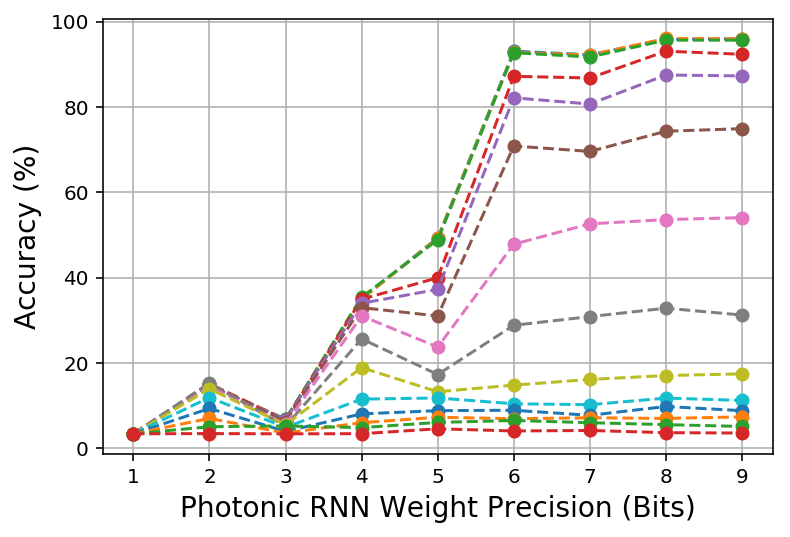

In [19]:
# noise_agg = np.stack(test_noise_acc).reshape(17,13)
f = plt.figure(figsize=(6,4))

data = []

for idx in range(len(snr_list)):
    plt.plot([int(np.log(precision_list[i]+1)/np.log(2)) for i in range(len(precision_list))], acc_precisions[idx], 'o--', label='CTRNN @ SNR={}dB'.format(snr_list[idx]))
    data.append([snr_list[idx], [int(np.log(precision_list[i]+1)/np.log(2)) for i in range(len(precision_list))], acc_precisions[idx]])
#     plt.plot(snr_list, noise_CTRNN[i,:], 'o-', label='CTRNN w/o noise')
#     plt.plot(snr_list, noise_CNN_noise[i,:], 'o--', label='CNN w/ noise')
#     plt.plot(snr_list, noise_CTRNN_noise[i,:], 'o-', label='CTRNN w/ noise')
plt.xlabel('Photonic RNN Weight Precision (Bits)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
# plt.legend()
# plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
# plt.savefig('61_39')
plt.grid(True)
plt.show()
# f.clear()

In [394]:
## save
import pickle
filename = '61_39'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [375]:
## load
infile = open(filename,'rb')
data_loaded = pickle.load(infile)
infile.close()

In [ ]:
## for 60_39, SNR-14, SNR-13, SNR-12, SNR-11 work pretty well

## for 61_39, SNR-13 and SNR-12 work well

## for 60x_39, SNR-10 work well

## Retrain the network with different SNR input data

In [346]:
import torch.optim as optim
hidden_size = 16
# input_size = 64
# output_size = 32
net = RNNNet(input_size=64, hidden_size=hidden_size, dt=5).to(DEVICE)

In [347]:
# Use Adam optimizer
learning_rate = 0.5e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
EPOCHS = 100
train_loader = trainloader_filter
dev_loader = devloader_filter
pred_new = []
labels_new = []
training_losses_new = []
mean_losses_new = []
val_losses_new = []
accuracies_new = []
epochs_no_improve = 0
n_epochs_stop = 10 
patience = 0
min_val_loss = 1e-2
early_stop = False
best_val_acc = 0.0
for epoch in range(EPOCHS):
    training_loss, mean_loss = train_noise(net, DEVICE, train_loader, optimizer, snr_list=np.array([60,61]))
    val_loss, accuracy, prediction, label = test_noise(net, DEVICE, dev_loader, snr_list=[39,39.5,40])
    labels_new.append(label)
    pred_new.append(prediction)
    training_losses_new += training_loss
    mean_losses_new.append(mean_loss)
    val_losses_new.append(val_loss)
    accuracies_new.append(accuracy)
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, dev_loss: {val_loss}, accuracy: {accuracy}", flush=True)
#     if (epoch+1) % 20 == 0:
#         learning_rate *= 0.8
#         optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    if accuracy <= best_val_acc:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            learning_rate *= 0.5
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            patience += 1
            print('patience:', patience, 'learning rate:', learning_rate)
            if patience == 3:
                print('Stop Training!' )
                break
            else:
                continue
        else:
            continue
        break 
    else:
        best_val_acc = accuracy
        epochs_no_improve = 0


100%|██████████| 34/34 [00:10<00:00,  3.31it/s]

epoch: 1, mean_loss: 2.4855858864607634, dev_loss: 2.2162757740241026, accuracy: 43.4705359786793



100%|██████████| 34/34 [00:10<00:00,  3.32it/s]

epoch: 2, mean_loss: 2.060797761987757, dev_loss: 1.9393547132659812, accuracy: 51.99881551673083



100%|██████████| 34/34 [00:08<00:00,  4.10it/s]

epoch: 3, mean_loss: 1.858653880490197, dev_loss: 1.7973150265156816, accuracy: 61.88925081433225



100%|██████████| 34/34 [00:08<00:00,  4.18it/s]

epoch: 4, mean_loss: 1.7585919389018305, dev_loss: 1.722914575153743, accuracy: 64.9096831507255



100%|██████████| 34/34 [00:09<00:00,  4.16it/s]

epoch: 5, mean_loss: 1.6872354948962176, dev_loss: 1.651582446223997, accuracy: 63.8732602901984



100%|██████████| 34/34 [00:08<00:00,  4.13it/s]

epoch: 6, mean_loss: 1.6332759632004632, dev_loss: 1.623487432997785, accuracy: 69.11459875629257



100%|██████████| 34/34 [00:08<00:00,  4.21it/s]

epoch: 7, mean_loss: 1.5892660057103192, dev_loss: 1.5654112838731562, accuracy: 67.66360675155464



100%|██████████| 34/34 [00:08<00:00,  4.13it/s]

epoch: 8, mean_loss: 1.550622570956195, dev_loss: 1.5296824457802856, accuracy: 71.57240153982825



100%|██████████| 34/34 [00:08<00:00,  4.21it/s]

epoch: 9, mean_loss: 1.5205620871649848, dev_loss: 1.5023661684912268, accuracy: 68.90731418418714



100%|██████████| 34/34 [00:08<00:00,  4.17it/s]

epoch: 10, mean_loss: 1.4888504536063583, dev_loss: 1.4788017374614233, accuracy: 66.44951140065146



100%|██████████| 34/34 [00:09<00:00,  3.81it/s]

epoch: 11, mean_loss: 1.4608519779311286, dev_loss: 1.4443896776266554, accuracy: 71.48356529464021



100%|██████████| 34/34 [00:10<00:00,  3.33it/s]

epoch: 12, mean_loss: 1.4396940602196588, dev_loss: 1.4288746373767078, accuracy: 71.72046194847498



100%|██████████| 34/34 [00:09<00:00,  3.56it/s]

epoch: 13, mean_loss: 1.4149718902729176, dev_loss: 1.4078464462872189, accuracy: 74.14865265028132



100%|██████████| 34/34 [00:08<00:00,  4.12it/s]

epoch: 14, mean_loss: 1.3983092829033181, dev_loss: 1.397371540063932, accuracy: 73.34912644358899



100%|██████████| 34/34 [00:08<00:00,  3.45it/s]

epoch: 15, mean_loss: 1.3736099234333745, dev_loss: 1.383275317552706, accuracy: 67.27864968907315



100%|██████████| 34/34 [00:10<00:00,  3.38it/s]

epoch: 16, mean_loss: 1.358265382272226, dev_loss: 1.3373531881506922, accuracy: 73.70447142434114



100%|██████████| 34/34 [00:09<00:00,  4.27it/s]

epoch: 17, mean_loss: 1.3411222338676452, dev_loss: 1.3131618646605325, accuracy: 77.37636955877998



100%|██████████| 34/34 [00:10<00:00,  3.37it/s]

epoch: 19, mean_loss: 1.3091849353578355, dev_loss: 1.3066779744670982, accuracy: 79.74533609712763



100%|██████████| 34/34 [00:08<00:00,  4.00it/s]

epoch: 20, mean_loss: 1.2989275340680724, dev_loss: 1.283281951816187, accuracy: 79.71572401539828



100%|██████████| 34/34 [00:08<00:00,  4.16it/s]

epoch: 21, mean_loss: 1.2790087306940998, dev_loss: 1.2567125175844327, accuracy: 79.74533609712763



100%|██████████| 34/34 [00:08<00:00,  4.17it/s]

epoch: 22, mean_loss: 1.2693451139662, dev_loss: 1.268793991694339, accuracy: 77.28753331359195



100%|██████████| 34/34 [00:08<00:00,  4.11it/s]

epoch: 23, mean_loss: 1.2617283436987135, dev_loss: 1.253396356462338, accuracy: 79.50843944329286



100%|██████████| 34/34 [00:08<00:00,  4.21it/s]

epoch: 25, mean_loss: 1.2393140187969913, dev_loss: 1.239291301520576, accuracy: 77.99822327509624



100%|██████████| 34/34 [00:10<00:00,  3.42it/s]

epoch: 26, mean_loss: 1.2219799982176887, dev_loss: 1.213903555334903, accuracy: 78.59046490968315



100%|██████████| 34/34 [00:10<00:00,  3.37it/s]

epoch: 27, mean_loss: 1.2105190400724057, dev_loss: 1.2522734646829656, accuracy: 74.2671009771987



100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

epoch: 28, mean_loss: 1.2030278589990404, dev_loss: 1.194268422611091, accuracy: 80.51525022209061



100%|██████████| 34/34 [00:08<00:00,  4.11it/s]

epoch: 29, mean_loss: 1.1994906182642335, dev_loss: 1.179025372422444, accuracy: 82.46964761622742



100%|██████████| 34/34 [00:09<00:00,  4.22it/s]

epoch: 30, mean_loss: 1.1883195576844392, dev_loss: 1.2650975138963876, accuracy: 72.72727272727273



100%|██████████| 34/34 [00:08<00:00,  4.16it/s]

epoch: 31, mean_loss: 1.172460714534477, dev_loss: 1.182870599691918, accuracy: 79.50843944329286



100%|██████████| 34/34 [00:09<00:00,  4.15it/s]

epoch: 32, mean_loss: 1.1687760887322602, dev_loss: 1.1519602554452324, accuracy: 82.17352679893396



100%|██████████| 34/34 [00:08<00:00,  4.15it/s]

epoch: 33, mean_loss: 1.161802003339485, dev_loss: 1.1739493317246825, accuracy: 78.11667160201362



100%|██████████| 34/34 [00:10<00:00,  3.38it/s]

epoch: 35, mean_loss: 1.1441313794365635, dev_loss: 1.1371008604985566, accuracy: 82.11430263547527



100%|██████████| 34/34 [00:08<00:00,  4.17it/s]

epoch: 36, mean_loss: 1.1390306108527712, dev_loss: 1.1429125238248572, accuracy: 83.53568255848386



100%|██████████| 34/34 [00:08<00:00,  4.28it/s]

epoch: 37, mean_loss: 1.135092079418677, dev_loss: 1.109272531267098, accuracy: 81.9366301450992



100%|██████████| 34/34 [00:08<00:00,  4.20it/s]

epoch: 38, mean_loss: 1.1219342560679824, dev_loss: 1.1117941865138765, accuracy: 81.9366301450992



100%|██████████| 34/34 [00:08<00:00,  4.14it/s]

epoch: 39, mean_loss: 1.1188044841642732, dev_loss: 1.1206618984810939, accuracy: 80.98904352976014



100%|██████████| 34/34 [00:08<00:00,  3.83it/s]

epoch: 40, mean_loss: 1.1084228292659477, dev_loss: 1.1233760934275638, accuracy: 83.80219129404797



100%|██████████| 34/34 [00:08<00:00,  4.22it/s]

epoch: 41, mean_loss: 1.1019611709647708, dev_loss: 1.130135253226224, accuracy: 79.36037903464613



100%|██████████| 34/34 [00:08<00:00,  3.65it/s]

epoch: 42, mean_loss: 1.10058411249408, dev_loss: 1.1099154805868803, accuracy: 84.89783831803376



100%|██████████| 34/34 [00:09<00:00,  3.38it/s]

epoch: 43, mean_loss: 1.0949049572149911, dev_loss: 1.1180055746497013, accuracy: 76.69529167900504



100%|██████████| 34/34 [00:09<00:00,  4.24it/s]

epoch: 44, mean_loss: 1.0885695506025244, dev_loss: 1.0890982388955868, accuracy: 84.48326917382292



 23%|██▎       | 63/270 [00:16<01:01,  3.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 34/34 [00:10<00:00,  3.37it/s]

epoch: 52, mean_loss: 1.0405846202815021, dev_loss: 1.0446724946731147, accuracy: 84.9866745632218



100%|██████████| 34/34 [00:10<00:00,  3.39it/s]

epoch: 53, mean_loss: 1.0395618323926572, dev_loss: 1.0160915334089853, accuracy: 88.03671898134439



100%|██████████| 34/34 [00:10<00:00,  3.38it/s]

epoch: 54, mean_loss: 1.0388037818449516, dev_loss: 1.0206753786124878, accuracy: 82.29197512585135



100%|██████████| 34/34 [00:08<00:00,  4.27it/s]

epoch: 55, mean_loss: 1.028582133628704, dev_loss: 1.0229043990223585, accuracy: 84.80900207284571



100%|██████████| 34/34 [00:08<00:00,  4.20it/s]

epoch: 56, mean_loss: 1.0184352267671515, dev_loss: 1.0215899018730183, accuracy: 82.73615635179154



100%|██████████| 34/34 [00:10<00:00,  3.40it/s]

epoch: 58, mean_loss: 1.01149246957567, dev_loss: 0.9927363161296578, accuracy: 89.51732306781167



100%|██████████| 34/34 [00:09<00:00,  4.17it/s]

epoch: 59, mean_loss: 1.0073955683796494, dev_loss: 1.0038654612901827, accuracy: 85.78620076991413



100%|██████████| 34/34 [00:09<00:00,  4.25it/s]

epoch: 60, mean_loss: 1.0102103588757692, dev_loss: 1.0302831846332634, accuracy: 84.09831211134143



100%|██████████| 34/34 [00:08<00:00,  4.03it/s]

epoch: 61, mean_loss: 0.9939770917097728, dev_loss: 0.9966026491267391, accuracy: 82.08469055374593



100%|██████████| 34/34 [00:08<00:00,  4.11it/s]

epoch: 62, mean_loss: 0.9931236845475656, dev_loss: 1.0081129259070525, accuracy: 86.6153390583358



100%|██████████| 34/34 [00:08<00:00,  4.26it/s]

epoch: 63, mean_loss: 0.9938246261190485, dev_loss: 0.9599999466484597, accuracy: 89.84305596683447



100%|██████████| 34/34 [00:10<00:00,  3.54it/s]

epoch: 64, mean_loss: 0.9831792871157329, dev_loss: 0.9794442524456717, accuracy: 85.13473497186853



100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

epoch: 65, mean_loss: 0.9776678612938634, dev_loss: 1.030333220482155, accuracy: 80.13029315960912



100%|██████████| 34/34 [00:08<00:00,  4.21it/s]

epoch: 67, mean_loss: 0.9741921104766704, dev_loss: 0.9577477872812928, accuracy: 85.78620076991413



100%|██████████| 34/34 [00:10<00:00,  3.39it/s]

epoch: 68, mean_loss: 0.9680564421194571, dev_loss: 0.987363319125866, accuracy: 85.3124074622446



100%|██████████| 34/34 [00:08<00:00,  4.20it/s]

epoch: 69, mean_loss: 0.9600435811060446, dev_loss: 0.9589696202999677, accuracy: 85.87503701510217



100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

epoch: 70, mean_loss: 0.9581286079353757, dev_loss: 0.9561965901152001, accuracy: 89.31003849570625



100%|██████████| 34/34 [00:09<00:00,  4.15it/s]

epoch: 71, mean_loss: 0.9550350590988442, dev_loss: 0.9437656433652201, accuracy: 87.44447734675748



100%|██████████| 34/34 [00:08<00:00,  4.26it/s]

epoch: 72, mean_loss: 0.9511041932635838, dev_loss: 0.9984272245051842, accuracy: 85.78620076991413



100%|██████████| 34/34 [00:10<00:00,  3.41it/s]

epoch: 73, mean_loss: 0.9491862937256142, dev_loss: 0.9661013758108394, accuracy: 84.95706248149244




  0%|          | 0/270 [00:00<?, ?it/s]

patience: 1 learning rate: 0.00025


100%|██████████| 34/34 [00:08<00:00,  4.28it/s]

epoch: 74, mean_loss: 0.930011468021958, dev_loss: 0.9215312722804527, accuracy: 90.58335801006811



100%|██████████| 34/34 [00:10<00:00,  3.42it/s]

epoch: 75, mean_loss: 0.9233944764843693, dev_loss: 0.9119079492132375, accuracy: 90.13917678412793



100%|██████████| 34/34 [00:09<00:00,  4.18it/s]

epoch: 83, mean_loss: 0.9048741294278039, dev_loss: 0.8940551931207831, accuracy: 91.32366005330175



100%|██████████| 34/34 [00:10<00:00,  3.38it/s]

epoch: 84, mean_loss: 0.9023633793548301, dev_loss: 0.8992763361988739, accuracy: 90.9683150725496



100%|██████████| 34/34 [00:08<00:00,  4.17it/s]

epoch: 85, mean_loss: 0.8982920801198041, dev_loss: 0.9050589551013498, accuracy: 88.33283979863785



100%|██████████| 34/34 [00:08<00:00,  4.28it/s]

epoch: 86, mean_loss: 0.8982620563771989, dev_loss: 0.8978919587546211, accuracy: 90.79064258217353




  0%|          | 0/270 [00:00<?, ?it/s]

patience: 2 learning rate: 0.000125


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]

epoch: 87, mean_loss: 0.887181094399205, dev_loss: 0.8799201952906307, accuracy: 92.30085875037015



100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

epoch: 88, mean_loss: 0.8874882294072045, dev_loss: 0.8863784680184367, accuracy: 91.2940479715724



100%|██████████| 34/34 [00:10<00:00,  3.39it/s]

epoch: 91, mean_loss: 0.8828805082374149, dev_loss: 0.8791369956945363, accuracy: 91.56055670713651



100%|██████████| 34/34 [00:08<00:00,  4.01it/s]

epoch: 92, mean_loss: 0.8803380303912692, dev_loss: 0.8761105712504298, accuracy: 91.85667752442997



100%|██████████| 34/34 [00:08<00:00,  4.26it/s]

epoch: 93, mean_loss: 0.8792442034792017, dev_loss: 0.8755917657858385, accuracy: 92.0047379330767



100%|██████████| 34/34 [00:09<00:00,  4.12it/s]

epoch: 94, mean_loss: 0.8796521926367724, dev_loss: 0.8721555766884237, accuracy: 91.97512585134734



100%|██████████| 34/34 [00:08<00:00,  4.27it/s]

epoch: 95, mean_loss: 0.8803040431605444, dev_loss: 0.8732900619506836, accuracy: 91.0275392360083



100%|██████████| 34/34 [00:10<00:00,  3.39it/s]

epoch: 96, mean_loss: 0.8762132770485348, dev_loss: 0.8667978374852843, accuracy: 92.44891915901688



100%|██████████| 34/34 [00:08<00:00,  4.28it/s]

epoch: 97, mean_loss: 0.8747533972616549, dev_loss: 0.8727662845020786, accuracy: 91.91590168788866



100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

epoch: 98, mean_loss: 0.8742011282179091, dev_loss: 0.8732536420124608, accuracy: 92.6562037311223



100%|██████████| 34/34 [00:08<00:00,  3.87it/s]

epoch: 99, mean_loss: 0.8730052446877515, dev_loss: 0.8692736291024047, accuracy: 92.06396209653539


In [348]:
save_model = True

if save_model:
    PATH = '/home/weipengz/'
    model_name = 'snr6061_39x_ctrnn.pt'
    torch.save(net.state_dict(), pjoin(PATH, model_name))

In [119]:
loaded = True
DEVICE = torch.device("cpu")
PATH = '/home/weipengz/'
# model_name = 'WM_photonic_ctrnn_7device_2CNN_1FC_len=32_neuron16_noise.pt' #_aplha01, none
model_name = 'snr40_ctrnn.pt'   
if loaded:
    net_test = RNNNet(input_size=64, hidden_size=16, dt=5).to(DEVICE)
    net_test.load_state_dict(torch.load(pjoin(PATH, model_name)))
test_loader = testloader_filter
# net_test.readout = False
val_loss, accuracy, prediction, label = test_noise(net_test, DEVICE, test_loader, snr_list=[30])
print('accuracy:', accuracy, val_loss)


100%|██████████| 33/33 [00:08<00:00,  3.85it/s]

accuracy: 90.85662211421628 0.9308002849685465
